# Regridding with xesmf

The [xesmf](https://pangeo-xesmf.readthedocs.io) library is a dask-aware regridding library, based on the Earth System Modelling Framework's regridder.

Let's use it to compare CMIP6 results with ERA5. These datasets are on different grids, so we need to regrid to compare them.

We can regrid in either direction, but always keep in mind that regridding never creates new information when you go from a coarse to fine resolution.

In [1]:
import xarray
import xesmf
import intake
import matplotlib.pyplot as plt
import dask.distributed

In [2]:
dask.distributed.Client()

Client Scheduler: tcp://127.0.0.1:44561 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 7.86 GB


To start out we'll load the data from the intake catalogue

In [3]:
dsd = (intake.cat.nci.esgf.cmip6.search(source_id='ACCESS-CM2', experiment_id='historical', variable_id='tas', member_id='r1i1p1f1', table_id='Amon')
       .to_dataset_dict(cdf_kwargs={'chunks': {'time': 120}}))
ds_cmip = list(dsd.values())[0]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version'


In [4]:
dsd = (intake.cat.nci.era5.search(product_type='reanalysis', year=2010, parameter='2t')
       .to_dataset_dict(cdf_kwargs={'chunks': {'time': 24, 'latitude': None, 'longitude': None}}))
ds_era5 = list(dsd.values())[0]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'sub_collection.dataset.product_type'


I've chosen the chunk sizes here to be the whole grid in the lat and lon dimensions and small in the time dimension, keeping the chunk size under 100 mb. The regridder runs on the whole horizontal plane at once, so there can't be any chunking in lat or lon

In [5]:
ds_cmip.tas.data

dask.array<open_dataset-2027b893f3854595ffea8ed7ec175fadtas, shape=(1980, 144, 192), dtype=float32, chunksize=(120, 144, 192), chunktype=numpy.ndarray>

In [6]:
ds_era5.t2m.data

dask.array<concatenate, shape=(8760, 721, 1440), dtype=float32, chunksize=(24, 721, 1440), chunktype=numpy.ndarray>

Using the xesmf regridder is simple, we just supply datasets for the source and target grids. Xesmf will automatically find the latitude and longitude dimensions, plus the bounds coordinates if available.

Since I'm just plotting the data I've chosen a bilinear regridding method. The options here are:
 * `'bilinear'`: Bilinear interpolation
 * `'patch'`: Smooth interpolation
 * `'nearest_s2d'`: Each destination point gets the nearest source point (nearest grid point interpolation)
 * `'nearest_d2s'`: Each source point goes to its nearest destination point (only once, so there will be gaps if going from a coarse to fine resolution)
 * `'conservative_normed'`: Retains the global sum before and after regridding, handles coastlines if masked
 * `'conservative'`: Retains the global sum before and after regridding, may have artefacts along the coastline if masked

The conservative methods are useful in coupled models where you want to conserve the quantities being regridded. Bilinear and patch are good for visualisation. See https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html for samples of each algorithm.

If your data is masked so that it only has valid data over certain areas (e.g. the land or ocean) you can tell xesmf this by adding a 'mask' variable to your dataset that is 1 in the valid areas and 0 for the grid points to ignore. A simple way to do this is

```python
ds['mask'] = xarray.where(numpy.isfinite(var), 1, 0)
```

Sometimes the masks of the two datasets don't perfectly align. In this case you can add `extrap_method` to the `Regridder()` arguments, which can be
 * `'inverse_dist'`: Extrapolated points are the mean of nearby points, inversely weighted by distance
 * `'nearest_s2d'`: Extrapolated points are from their nearest unmasked source grid point
 
There are additional arguments that can be used if desired to set up the `inverse_dist` extrapolation, but generally the defaults are fine.

Finally, if you have a global grid let xesmf know by saying `periodic=True`, otherwise the edges of the grid won't line up with each other.

In [7]:
regrid_cmip_to_era5 = xesmf.Regridder(ds_cmip, ds_era5, method='bilinear', periodic=True)

The regridding is Dask-aware, so you can give it a large dataset and it will only compute the time-slices you actually use when you make a plot or save the result to a file

In [8]:
tas = regrid_cmip_to_era5(ds_cmip.tas)
tas

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'tas' (time: 1980, latitude: 721, longitude: 1440)>
dask.array<transpose, shape=(1980, 721, 1440), dtype=float64, chunksize=(120, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    regrid_method:  bilinear

We can now compare the two datasets. Here I've done the regrid from the coarse ACCESS-CM2 grid to the fine ERA5 grid. It looks nice, but most of the fine detail is just coming from the ERA5 data, since it uses a 0.25 degree grid. When analysing the data you wouldn't want to look at scales any smaller than the coarse grid - about 1.5 degrees in this case.

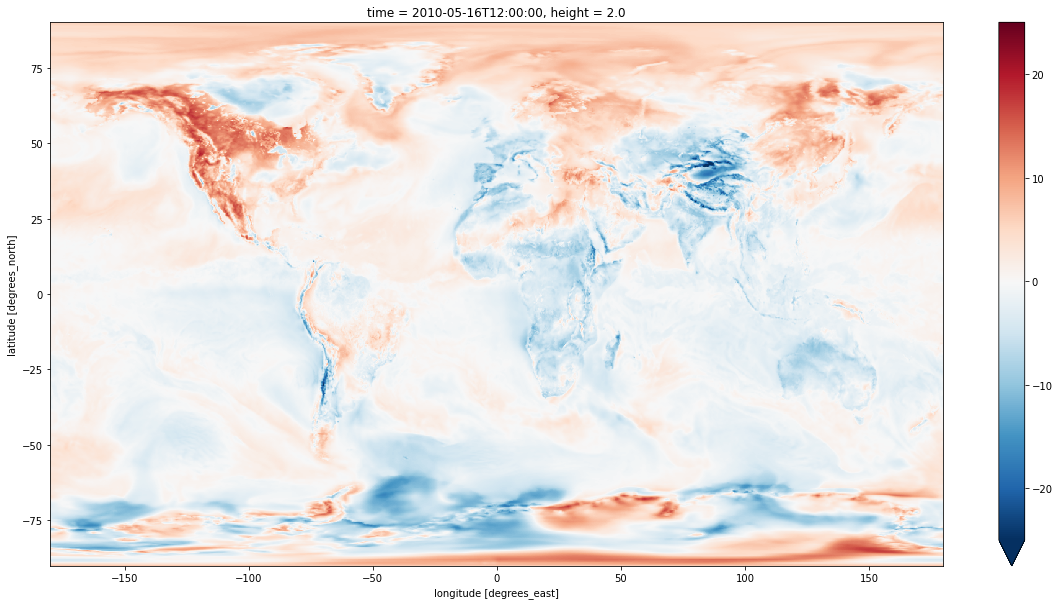

In [9]:
delta_era5_grid = ds_era5.t2m.sel(time='2010-05-16T00:00') - tas.sel(time='2010-05-16', method='nearest')

plt.figure(figsize=(20,10))
delta_era5_grid.plot(vmax=25)

Regridding in the other direction works exactly the same way. The result is consistent with the high resolution grid, although a bit blockier because of the coarser resolution. The useful information is the same in both directions, going from fine to coarse just makes this more explicit.

In [10]:
regrid_era5_to_cmip = xesmf.Regridder(ds_era5, ds_cmip, method='bilinear', periodic=True)

In [11]:
t2m = regrid_era5_to_cmip(ds_era5.t2m)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


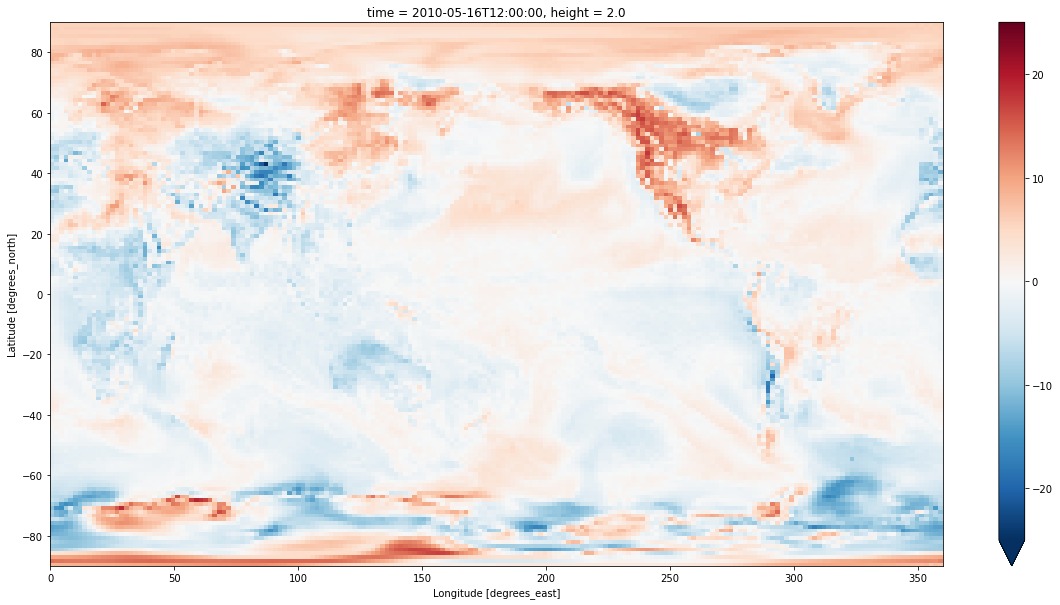

In [12]:
delta_cmip5_grid = t2m.sel(time='2010-05-16T00:00') - ds_cmip.tas.sel(time='2010-05-16', method='nearest')

plt.figure(figsize=(20,10))
delta_cmip5_grid.plot(vmax=25)